In [68]:
import torch
from torch import nn

import numpy as np

import matplotlib.pyplot  as plt

from sklearn.model_selection import train_test_split

In [70]:
w = np.array([3, -5, -12, 5, 1])

start = -1.2
end = 1.3
step = 0.01

def calc_poly(X, w):
    sum = 0
    size = len(w) -1
    for i, wi in enumerate(w):
        sum += wi * X.pow(size -i)
    return sum

X = torch.arange(start,end,step).unsqueeze(dim=1)

# Y = np.polyval(w, X)
Y = calc_poly(X, w)


In [71]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)
len(X_train), len(X_test), len(Y_train), len(Y_test)

(187, 63, 187, 63)

In [73]:
def plot_predictions(
    train_data=X_train,
    train_labels=Y_train,
    test_data=X_test,
    test_labels=Y_test,
    predictions=None,
    pred_data=None,
    pred_labels=None,
):
    plt.figure(figsize=(10, 7))

    train_data = train_data.cpu()
    train_labels = train_labels.cpu()
    plt.scatter(train_data, train_labels, c="b", s=4, label="Train data")

    test_data = test_data.cpu()
    test_labels = test_labels.cpu()
    plt.scatter(test_data, test_labels, c="orange", s=4, label="Test data")

    if predictions is not None:
        predictions = predictions.cpu()
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    if pred_data is not None and pred_labels is not None:
        pred_data = pred_data.cpu()
        pred_labels = pred_labels.cpu()
        plt.scatter(pred_data, pred_labels, c="black", s=4, label="Pred data 2")

    plt.legend(prop={"size": 14})

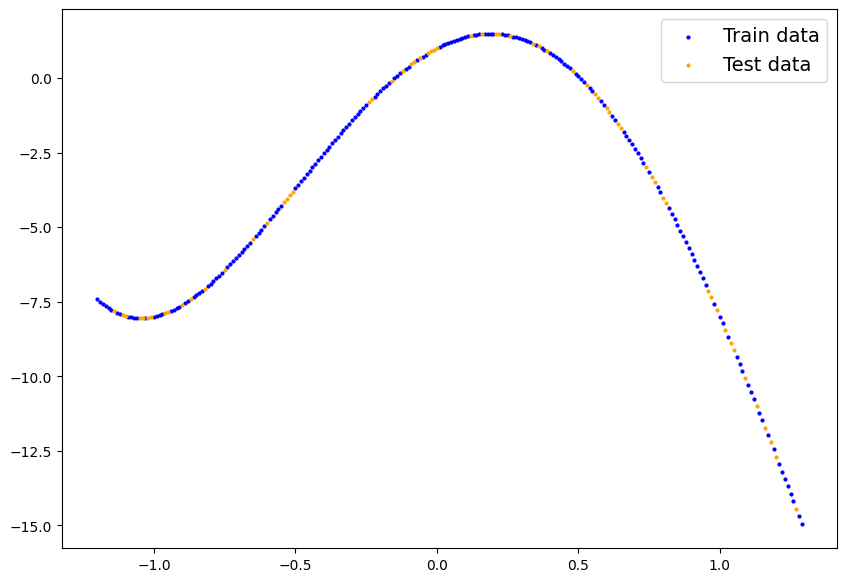

In [74]:
plot_predictions(
    train_data=X_train,
    train_labels=Y_train,
    test_data=X_test,
    test_labels=Y_test,
)

In [75]:
class QuadraticModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.w = nn.Parameter(torch.randn(5, requires_grad=True))
    
    def forward(self, x):
        # return self.w3*x.pow(3) + self.w2*x.pow(2) + self.w1*x + self.w0
        return calc_poly(x, self.w)

In [76]:
torch.manual_seed(42)

model_0 = QuadraticModel()
w, model_0.state_dict()

(array([  3,  -5, -12,   5,   1]),
 OrderedDict([('w',
               tensor([ 0.1940,  2.1614, -0.1721,  0.8491, -1.9244], device='cuda:0'))]))

In [77]:
with torch.inference_mode():
    Y_pred = model_0(X_test)

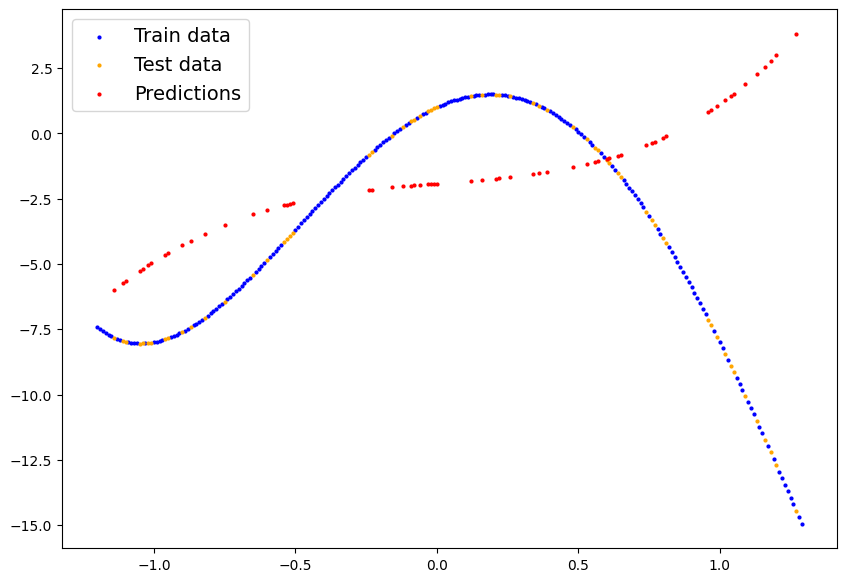

In [78]:
plot_predictions(
    train_data=X_train,
    train_labels=Y_train,
    test_data=X_test,
    test_labels=Y_test,
    predictions=Y_pred,
)

In [79]:
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(model_0.parameters(), 0.001, 0.9)

In [80]:
w, model_0.state_dict()

(array([  3,  -5, -12,   5,   1]),
 OrderedDict([('w',
               tensor([ 0.1940,  2.1614, -0.1721,  0.8491, -1.9244], device='cuda:0'))]))

In [85]:
epochs = 10000

epoch_count = []
loss_values = []
test_loss_values = []

for epoch in range(epochs):
    model_0.train()

    Y_pred = model_0(X_train)

    loss = loss_fn(Y_pred, Y_train)
    # # print(f'  loss: {loss}')

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    # Testing
    model_0.eval()
    with torch.inference_mode():
        test_pred = model_0(X_test)

        test_loss = loss_fn(test_pred, Y_test)

        epoch_count.append(epoch)
        loss_values.append(loss.detach().cpu())
        test_loss_values.append(test_loss.cpu())

        if epoch % 1000 == 0:
            print(f'Epoch: {epoch}')
            print(f'  Loss: {loss}')
            print(f'  Test Loss: {test_loss}')

Epoch: 0
  Loss: 0.38537630438804626
  Test Loss: 0.36115017533302307
Epoch: 1000
  Loss: 0.29192641377449036
  Test Loss: 0.27574583888053894
Epoch: 2000
  Loss: 0.19967611134052277
  Test Loss: 0.18912173807621002
Epoch: 3000
  Loss: 0.10799647867679596
  Test Loss: 0.10265883803367615
Epoch: 4000
  Loss: 0.016401616856455803
  Test Loss: 0.015530165284872055
Epoch: 5000
  Loss: 0.0005254471325315535
  Test Loss: 0.0008406677516177297
Epoch: 6000
  Loss: 0.001077005872502923
  Test Loss: 0.0018383085262030363
Epoch: 7000
  Loss: 0.0019058234756812453
  Test Loss: 0.001037301612086594
Epoch: 8000
  Loss: 0.001030809129588306
  Test Loss: 0.0013981614029034972
Epoch: 9000
  Loss: 0.001339415553957224
  Test Loss: 0.0019947225227952003


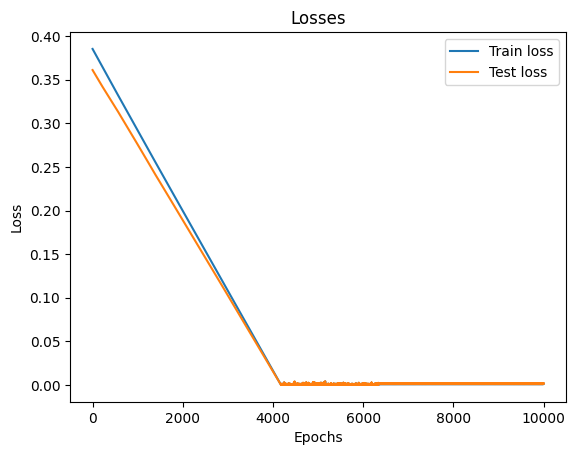

In [87]:
# Plot loss
plt.plot(epoch_count, loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [88]:
with torch.inference_mode():
    Y_pred = model_0(X_test)

In [89]:
w, model_0.state_dict()

(array([  3,  -5, -12,   5,   1]),
 OrderedDict([('w',
               tensor([  3.0009,  -4.9994, -11.9995,   5.0001,   1.0012], device='cuda:0'))]))

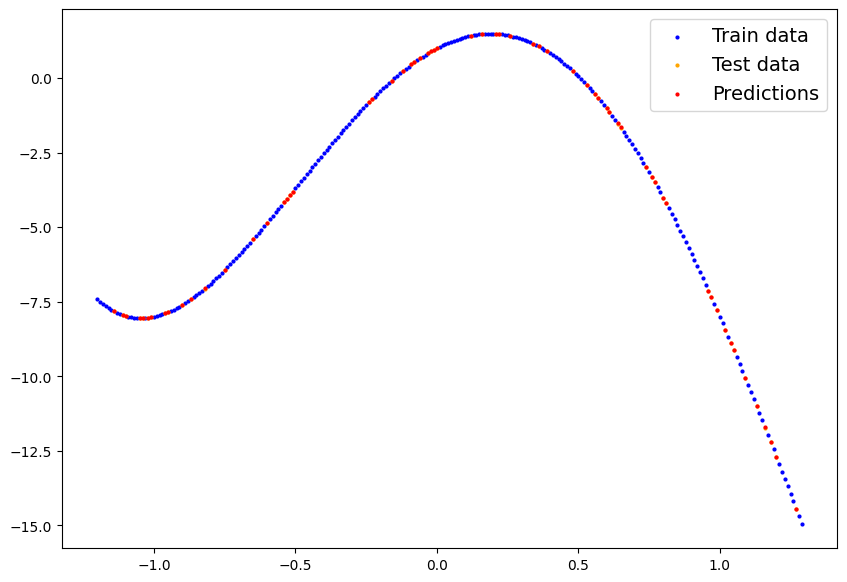

In [90]:
plot_predictions(
    predictions=Y_pred,
)

In [91]:
# Saving
from pathlib import Path

MODELS_PATH = Path('models')
MODELS_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = Path('02_polynomial.pt')
MODEL_PATH = MODELS_PATH / MODEL_NAME
print(MODEL_PATH)

# torch.save(model_0.state_dict(), MODEL_PATH)

models/02_polynomial.pt


In [92]:
# Loading
model_1 = QuadraticModel()
model_1.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [93]:
model_1.eval()
with torch.inference_mode():
    Y_pred = model_1(X_test)


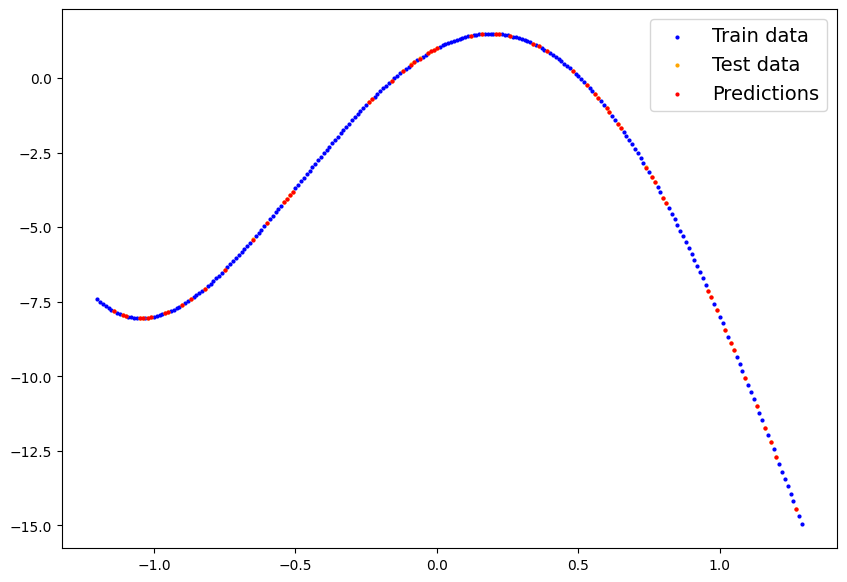

In [94]:
plot_predictions(predictions=Y_pred)